In [ ]:
from torchvision.datasets import KMNIST

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

In [ ]:

transform = transforms.Compose([

    transforms.ToTensor(),

])

In [ ]:
train_dataset = KMNIST(root="./data", train = True, transform=transform, download=True)
test_dataset = KMNIST(root="./data", train = False, transform=transform, download=True)
classes = train_dataset.classes
len(train_dataset), len(test_dataset)

100%|██████████| 18.2M/18.2M [00:08<00:00, 2.04MB/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 371kB/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 1.72MB/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 9.63MB/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



(60000, 10000)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
print(classes)

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


ya


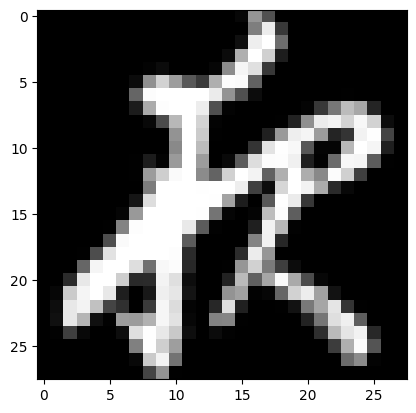

su


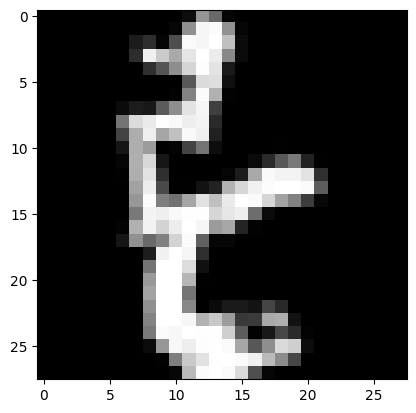

na


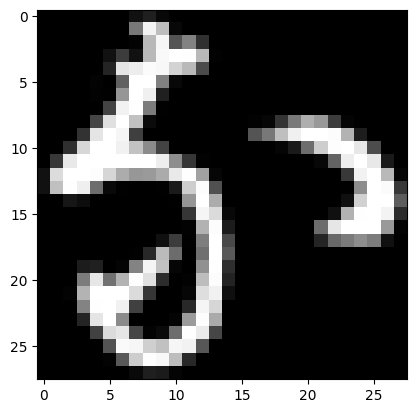

o


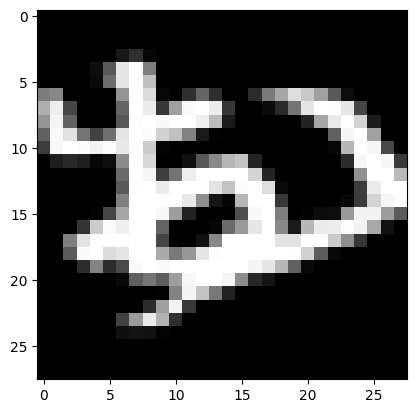

ki


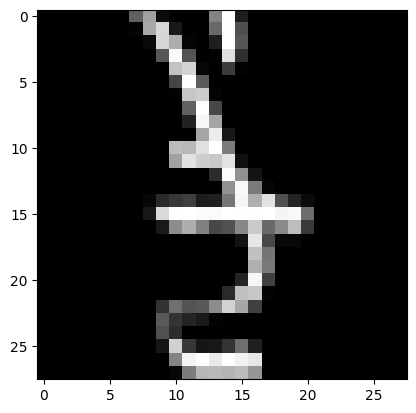

na


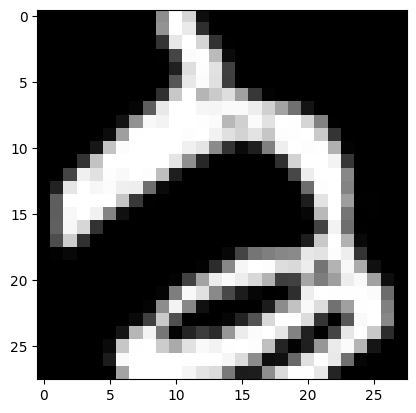

ha


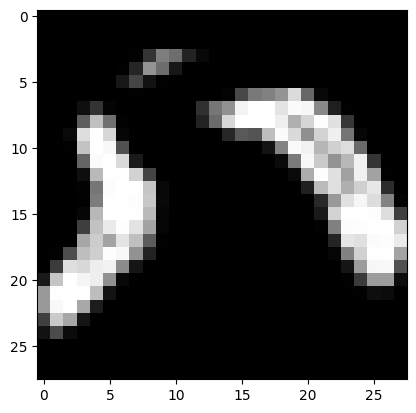

wo


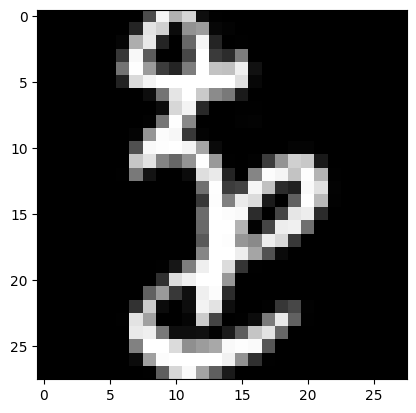

na


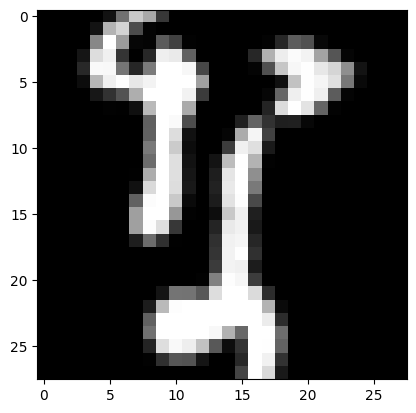

wo


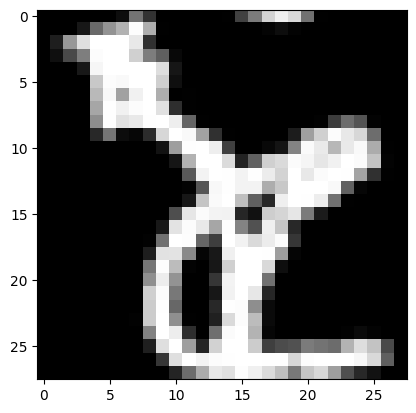

ma


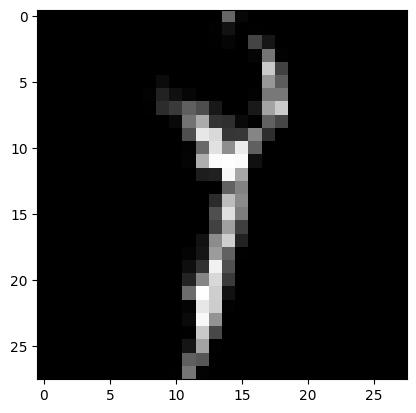

ya


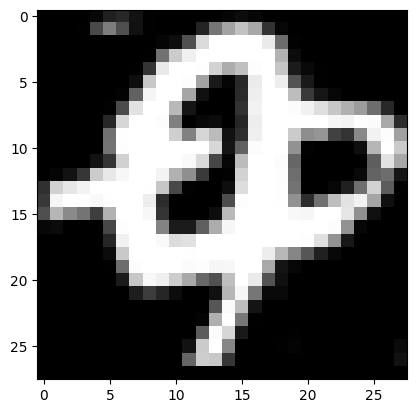

re


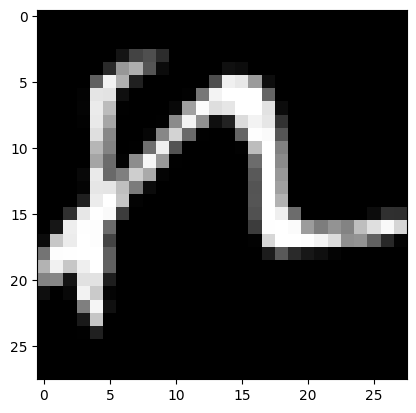

su


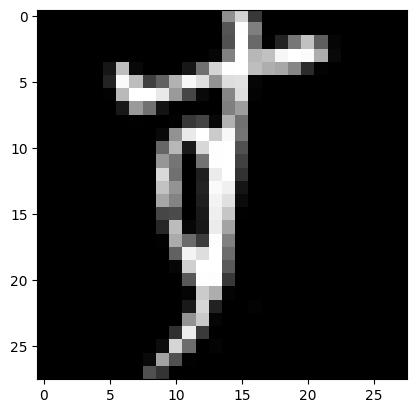

o


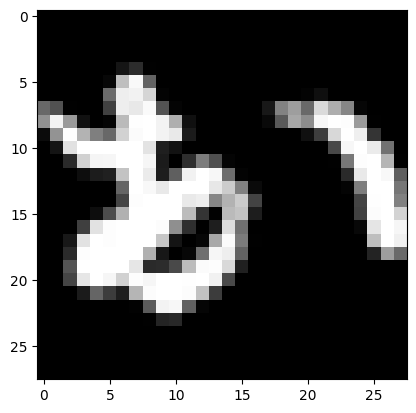

ha


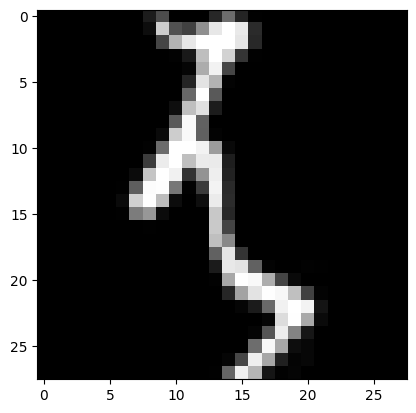

o


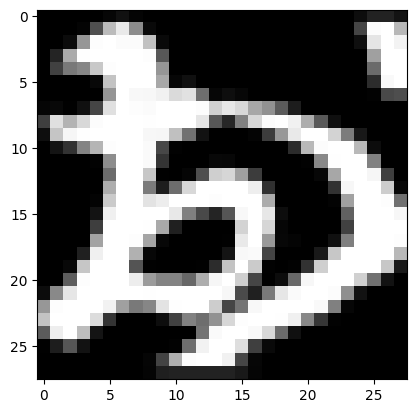

re


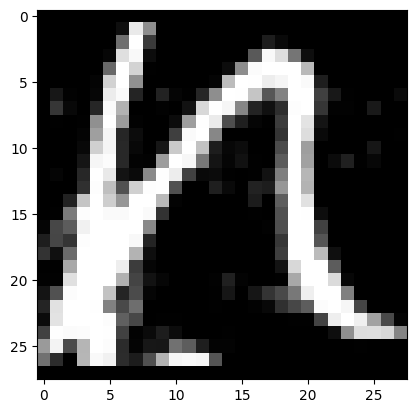

o


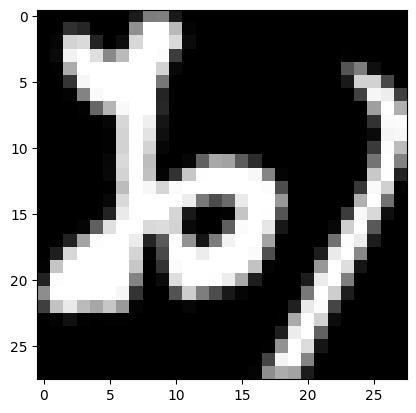

ki


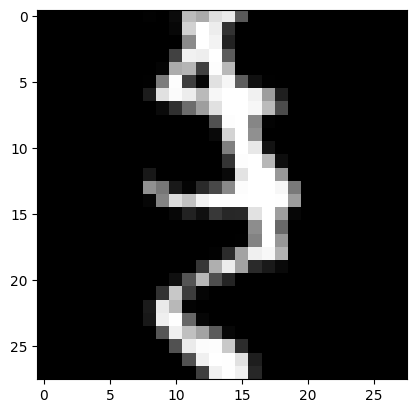

ha


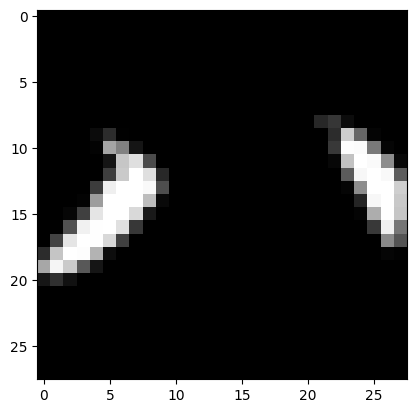

su


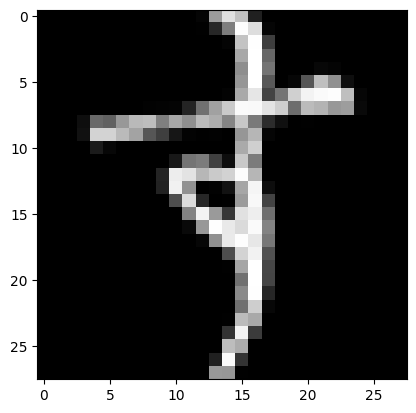

tsu


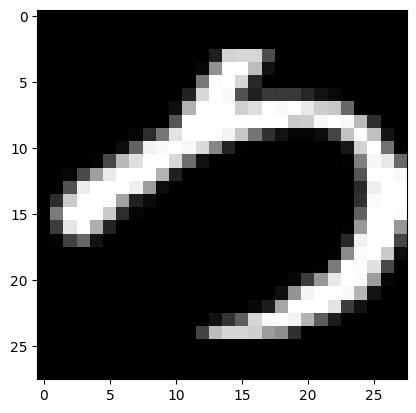

wo


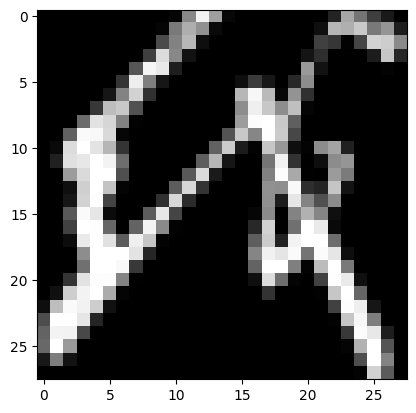

wo


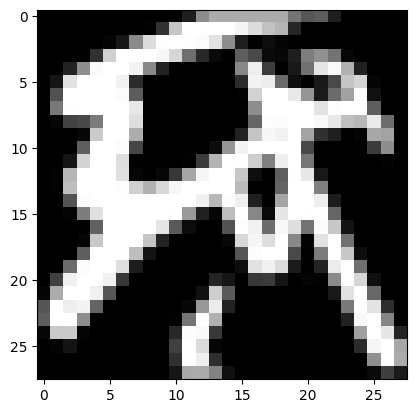

ma


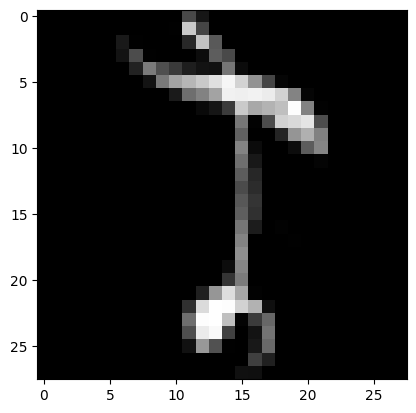

na


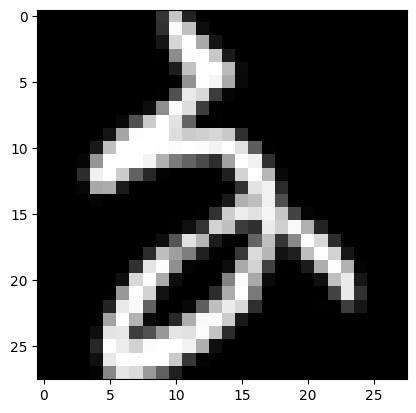

tsu


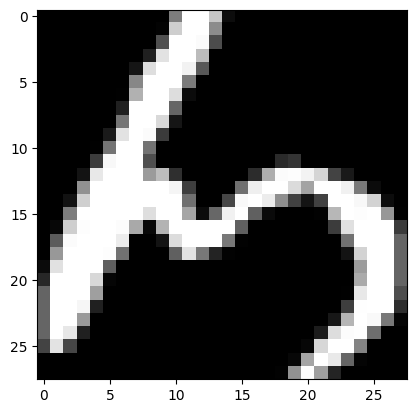

o


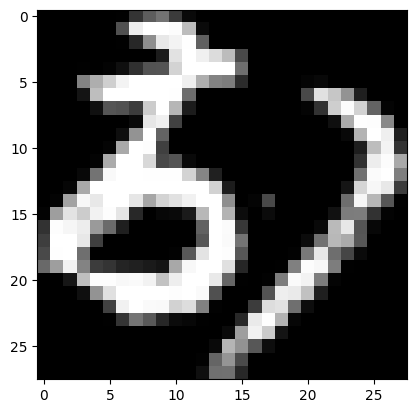

ha


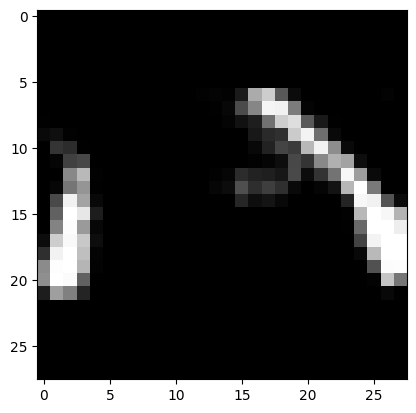

ha


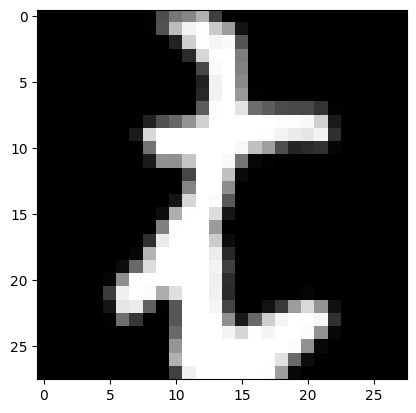

ki


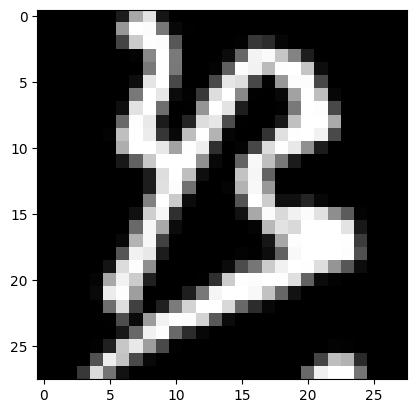

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_loader:
    for i in range(32):
      print(classes[labels[i]])
      plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
      plt.show()
    break

In [ ]:
from torch import nn

class BaselineModel(nn.Module):
    def __init__(self, num_classes):
        super(BaselineModel, self).__init__()

        # Layer 1: Convolutional layer + ReLU (non-linear activation 1)
        #image size is 28 x 28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()

        # Layer 2: Convolutional layer + ReLU (non-linear activation 2)
          #image size is 26 x 26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3: Convolutional layer + ReLU (non-linear activation 3)
          #image size is 12 x 12
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 4: Fully connected layer + ReLU (non-linear activation 4)
          #image size is 5 x 5
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 5 * 5 , 512)
        self.relu4 = nn.ReLU()

        # Layer 5: Fully connected layer + ReLU (non-linear activation 5)
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()

        # Output layer
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):

        x = (self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))


        x = self.flatten(x)


        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
model3 = BaselineModel(10)
!pip install torchinfo

import torchinfo
torchinfo.summary(model=model3,
        input_size=(32, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
BaselineModel (BaselineModel)            [32, 1, 28, 28]      [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 1, 28, 28]      [32, 32, 26, 26]     320                  True
├─ReLU (relu1)                           [32, 32, 26, 26]     [32, 32, 26, 26]     --                   --
├─Conv2d (conv2)                         [32, 32, 26, 26]     [32, 64, 24, 24]     18,496               True
├─ReLU (relu2)                           [32, 64, 24, 24]     [32, 64, 24, 24]     --                   --
├─MaxPool2d (pool2)                      [32, 64, 24, 24]     [32, 64, 12, 12]     --                   --
├─Conv2d (conv3)                         [32, 64, 12, 12]     [32, 128, 10, 10]    73,856               True
├─ReLU (relu3)                           [32, 128, 10, 10]    [32, 128, 10, 10]    --                   --
├─MaxPool2d (pool3)   

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [ ]:
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, scheduler=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        print(epoch)
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _,predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.3f}, Test Loss: {epoch_val_loss:.3f} Train Acc: {epoch_train_acc:.3f}, Test Acc: {epoch_val_acc:.3f}')

    return train_loss_history, val_loss_history, val_acc_history

def plot_training_results(train_loss_history, val_loss_history, val_acc_history):

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss curves
    epochs = range(1, len(train_loss_history) + 1)
    ax1.plot(epochs, train_loss_history, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy curve
    ax2.plot(epochs, val_acc_history, 'g-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def test_model(model, test_loader):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy

def save_model(model, filepath='_classifier.pt'):

    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='_classifier.pt', num_classes=37):

    model = model_class(num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {filepath}")
    return model

Using device: cuda
0
Epoch 0, Train Loss: 0.399, Test Loss: 0.287 Train Acc: 86.972, Test Acc: 91.740
1
Epoch 1, Train Loss: 0.073, Test Loss: 0.206 Train Acc: 97.773, Test Acc: 94.160
2
Epoch 2, Train Loss: 0.038, Test Loss: 0.178 Train Acc: 98.832, Test Acc: 95.190
3
Epoch 3, Train Loss: 0.022, Test Loss: 0.211 Train Acc: 99.312, Test Acc: 94.820
4
Epoch 4, Train Loss: 0.012, Test Loss: 0.198 Train Acc: 99.640, Test Acc: 95.710
5
Epoch 5, Train Loss: 0.009, Test Loss: 0.214 Train Acc: 99.720, Test Acc: 95.710
6
Epoch 6, Train Loss: 0.007, Test Loss: 0.230 Train Acc: 99.805, Test Acc: 95.480
7
Epoch 7, Train Loss: 0.007, Test Loss: 0.217 Train Acc: 99.775, Test Acc: 95.630
8
Epoch 8, Train Loss: 0.005, Test Loss: 0.225 Train Acc: 99.842, Test Acc: 95.590
9
Epoch 9, Train Loss: 0.003, Test Loss: 0.280 Train Acc: 99.903, Test Acc: 95.380
10
Epoch 10, Train Loss: 0.003, Test Loss: 0.245 Train Acc: 99.915, Test Acc: 95.650
11
Epoch 11, Train Loss: 0.002, Test Loss: 0.226 Train Acc: 99.950

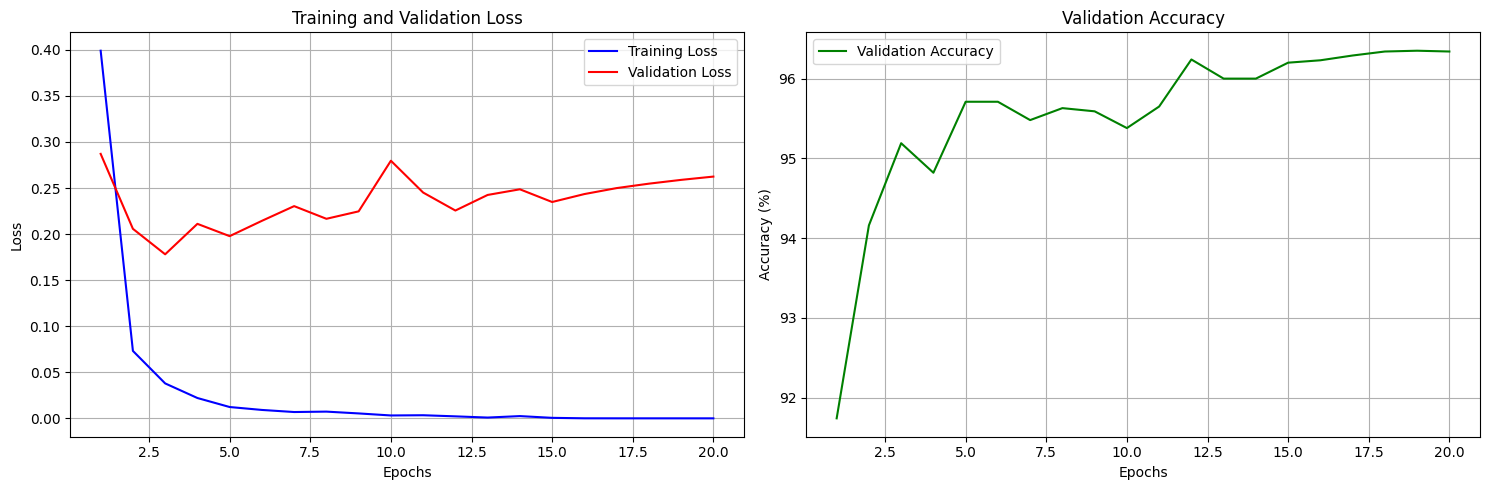

Test Accuracy: 96.34%
Model saved to _classifier_baseline.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize your model
num_classes = 10
model = BaselineModel(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train model
train_loss, val_loss, val_acc = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,  # Using test_loader as validation
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20,
    # scheduler=scheduler
)

# Plot results
plot_training_results(train_loss, val_loss, val_acc)

# Evaluate on test set
final_accuracy = test_model(model, test_loader)

# Save the model
save_model(model, filepath='_classifier_baseline.pt')

# To load the model later (uncomment when needed)
# loaded_model = load_model(DropoutModel, filepath='pet_classifier_dropout.pt')

In [ ]:
from torch import nn

class DropoutModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(DropoutModel, self).__init__()
        self.flatten = nn.Flatten()

        # Layer 1: Convolutional layer + ReLU (non-linear activation 1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout1 = nn.Dropout(dropout_rate)

        # Layer 2: Convolutional layer + ReLU (non-linear activation 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3: Convolutional layer + ReLU (non-linear activation 3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.dropout3 = nn.Dropout(dropout_rate)

        # Layer 4: Fully connected layer + ReLU (non-linear activation 4)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)

        # Layer 5: Fully connected layer + ReLU (non-linear activation 5)
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(dropout_rate)

        # Output layer
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Apply layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = (self.pool2(self.relu2(self.conv2(x))))
        x = (self.pool3(self.relu3(self.conv3(x))))
        x = self.flatten(x)

        # Fully connected layers
        x = self.dropout4(self.relu4(self.fc1(x)))
        x = self.dropout5(self.relu5(self.fc2(x)))
        x = self.fc3(x)

        return x


Using device: cuda
0
Epoch 0, Train Loss: 0.300, Test Loss: 0.247 Train Acc: 90.407, Test Acc: 92.510
1
Epoch 1, Train Loss: 0.088, Test Loss: 0.188 Train Acc: 97.345, Test Acc: 94.410
2
Epoch 2, Train Loss: 0.061, Test Loss: 0.205 Train Acc: 98.212, Test Acc: 94.420
3
Epoch 3, Train Loss: 0.048, Test Loss: 0.172 Train Acc: 98.553, Test Acc: 95.210
4
Epoch 4, Train Loss: 0.041, Test Loss: 0.137 Train Acc: 98.782, Test Acc: 96.360
5
Epoch 5, Train Loss: 0.036, Test Loss: 0.171 Train Acc: 98.907, Test Acc: 95.810
6
Epoch 6, Train Loss: 0.034, Test Loss: 0.181 Train Acc: 98.992, Test Acc: 95.530
7
Epoch 7, Train Loss: 0.030, Test Loss: 0.145 Train Acc: 99.112, Test Acc: 96.370
8
Epoch 8, Train Loss: 0.028, Test Loss: 0.135 Train Acc: 99.148, Test Acc: 96.590
9
Epoch 9, Train Loss: 0.025, Test Loss: 0.183 Train Acc: 99.227, Test Acc: 95.180
10
Epoch 10, Train Loss: 0.026, Test Loss: 0.165 Train Acc: 99.228, Test Acc: 96.350
11
Epoch 11, Train Loss: 0.024, Test Loss: 0.133 Train Acc: 99.253

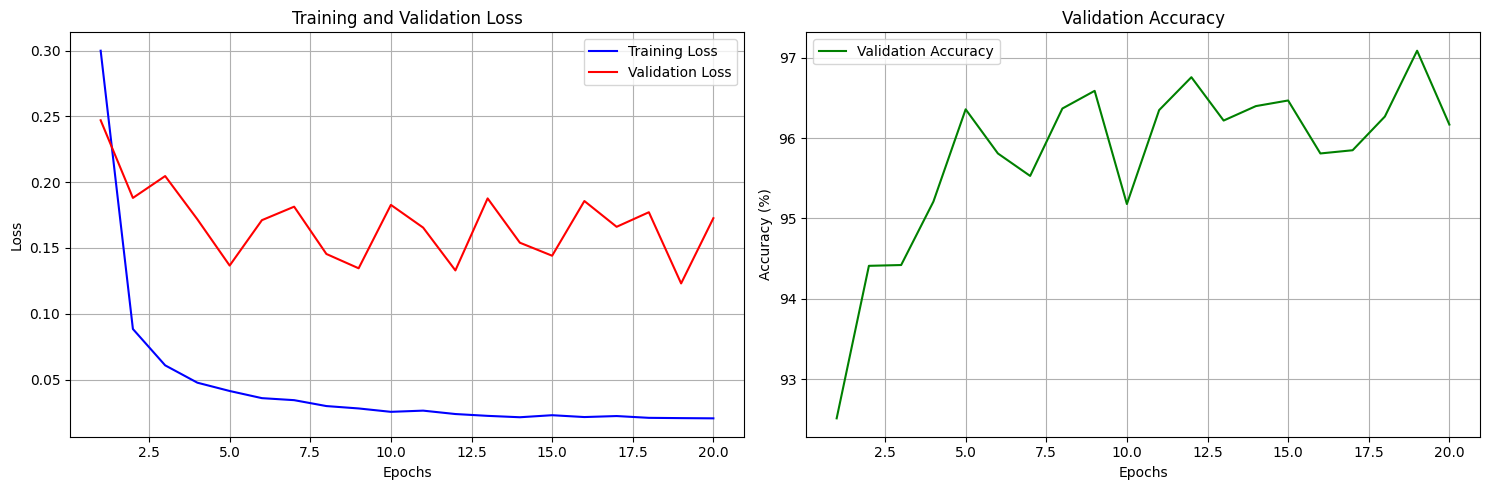

Test Accuracy: 96.17%
Model saved to _classifier_dropout.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize your model
num_classes = 10
model = DropoutModel(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train model
train_loss, val_loss, val_acc = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,  # Using test_loader as validation
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20,
    # scheduler=scheduler
)

# Plot results
plot_training_results(train_loss, val_loss, val_acc)

# Evaluate on test set
final_accuracy = test_model(model, test_loader)

# Save the model
save_model(model, filepath='_classifier_dropout.pt')

# To load the model later (uncomment when needed)
# loaded_model = load_model(DropoutModel, filepath='pet_classifier_dropout.pt')

In [ ]:
# Example code to create reduced training sets
from torch.utils.data import Subset
import numpy as np

def create_stratified_subset(dataset, percentage):
    # Get class distribution
    targets = dataset.targets.numpy()
    classes = np.unique(targets)

    # Create indices for stratified sampling
    subset_indices = []
    for c in classes:
        class_indices = np.where(targets == c)[0]
        subset_size = int(len(class_indices) * percentage)
        subset_indices.extend(np.random.choice(class_indices, subset_size, replace=False))

    return Subset(dataset, subset_indices)

# Create subsets
train_25 = create_stratified_subset(train_dataset, 0.25)
train_50 = create_stratified_subset(train_dataset, 0.50)
train_75 = create_stratified_subset(train_dataset, 0.75)

# Create DataLoaders
train_loader_25 = DataLoader(train_25, batch_size=32, shuffle=True, num_workers=2)
train_loader_50 = DataLoader(train_50, batch_size=32, shuffle=True, num_workers=2)
train_loader_75 = DataLoader(train_75, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate precision and recall for each class
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)

    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')

    return precision, recall

In [ ]:
# Example results tracking
results = {
    'baseline': {
        '25%': {'accuracy': 0, 'precision': 0, 'recall': 0},
        '50%': {'accuracy': 0, 'precision': 0, 'recall': 0},
        '75%': {'accuracy': 0, 'precision': 0, 'recall': 0},
        '100%': {'accuracy': 0, 'precision': 0, 'recall': 0}
    },
    'dropout': {
        '25%': {'accuracy': 0, 'precision': 0, 'recall': 0},
        '50%': {'accuracy': 0, 'precision': 0, 'recall': 0},
        '75%': {'accuracy': 0, 'precision': 0, 'recall': 0},
        '100%': {'accuracy': 0, 'precision': 0, 'recall': 0}
    },
}


In [ ]:
import numpy as np
from torch.utils.data import Subset, DataLoader

def create_stratified_subset(dataset, percentage):

    # Get all targets
    targets = np.array(dataset.targets)
    classes = np.unique(targets)

    # Create indices for stratified sampling
    subset_indices = []
    for c in classes:
        class_indices = np.where(targets == c)[0]
        subset_size = int(len(class_indices) * percentage)
        subset_indices.extend(np.random.choice(class_indices, subset_size, replace=False))

    return Subset(dataset, subset_indices)

# Create stratified subsets of the training data
train_25 = create_stratified_subset(train_dataset, 0.25)
train_50 = create_stratified_subset(train_dataset, 0.50)
train_75 = create_stratified_subset(train_dataset, 0.75)
train_100 = train_dataset  # Original full dataset

# Create DataLoaders for different dataset sizes
batch_size = 32
train_loader_25 = DataLoader(train_25, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_50 = DataLoader(train_50, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_75 = DataLoader(train_75, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_100 = train_loader  # Original full dataset loader

# Print dataset sizes to verify
print(f"25% Training Set Size: {len(train_25)}")
print(f"50% Training Set Size: {len(train_50)}")
print(f"75% Training Set Size: {len(train_75)}")
print(f"100% Training Set Size: {len(train_100)}")

25% Training Set Size: 15000
50% Training Set Size: 30000
75% Training Set Size: 45000
100% Training Set Size: 60000


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 1. L2 Weight Regularization (weight decay in optimizer)
def train_with_l2_regularization(model_class, train_loader, test_loader, num_epochs=50, weight_decay=1e-4):

    model = model_class(num_classes=10)
    criterion = nn.CrossEntropyLoss()

    # Using SGD with weight decay for L2 regularization
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)

    # Train the model
    train_loss, val_loss, val_acc = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=num_epochs
    )

    return model, train_loss, val_loss, val_acc

# 2. Data Augmentation
def create_augmented_dataset():

    # Define augmentation transforms
    augmentation_transform = transforms.Compose([
        transforms.RandomRotation(10),  # Rotate by up to 10 degrees
        transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Shift image by up to 10%
        transforms.ToTensor(),  # Convert to tensor
    ])

    # Create augmented training datasets
    augmented_train_25 = KMNIST(root="./data", train=True, transform=augmentation_transform, download=False)
    augmented_train_50 = KMNIST(root="./data", train=True, transform=augmentation_transform, download=False)
    augmented_train_75 = KMNIST(root="./data", train=True, transform=augmentation_transform, download=False)
    augmented_train_100 = KMNIST(root="./data", train=True, transform=augmentation_transform, download=False)

    # Create stratified subsets
    aug_train_25 = create_stratified_subset(augmented_train_25, 0.25)
    aug_train_50 = create_stratified_subset(augmented_train_50, 0.50)
    aug_train_75 = create_stratified_subset(augmented_train_75, 0.75)
    aug_train_100 = augmented_train_100

    # Create DataLoaders
    aug_train_loader_25 = DataLoader(aug_train_25, batch_size=batch_size, shuffle=True, num_workers=2)
    aug_train_loader_50 = DataLoader(aug_train_50, batch_size=batch_size, shuffle=True, num_workers=2)
    aug_train_loader_75 = DataLoader(aug_train_75, batch_size=batch_size, shuffle=True, num_workers=2)
    aug_train_loader_100 = DataLoader(aug_train_100, batch_size=batch_size, shuffle=True, num_workers=2)

    return {
        '25%': aug_train_loader_25,
        '50%': aug_train_loader_50,
        '75%': aug_train_loader_75,
        '100%': aug_train_loader_100
    }

# Create augmented dataloaders
augmented_loaders = create_augmented_dataset()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

def evaluate_model_metrics(model, test_loader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    # Calculate precision and recall for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)

    metrics_dict = {
        'accuracy': accuracy,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'per_class_precision': precision,
        'per_class_recall': recall
    }

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')

    # Optional: Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    return metrics_dict

In [ ]:
def run_experiments(num_epochs=20):

    # Initialize results dictionary
    results = {
        'baseline': {
            '25%': {}, '50%': {}, '75%': {}, '100%': {}
        },
        'dropout': {
            '25%': {}, '50%': {}, '75%': {}, '100%': {}
        },
        'l2_regularization': {
            '25%': {}, '50%': {}, '75%': {}, '100%': {}
        },
        'data_augmentation': {
            '25%': {}, '50%': {}, '75%': {}, '100%': {}
        }
    }

    # Data loaders for different dataset sizes
    train_loaders = {
        '25%': train_loader_25,
        '50%': train_loader_50,
        '75%': train_loader_75,
        '100%': train_loader_100
    }

    # 1. Baseline Model Experiments
    print("\nRunning Baseline Model Experiments ")
    for size, loader in train_loaders.items():
        print(f"\nTraining Baseline Model with {size} data")

        # Initialize model
        model = BaselineModel(num_classes=10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.1)

        # Train model
        train_loss, val_loss, val_acc = train_model(
            model=model,
            train_loader=loader,
            val_loader=test_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_epochs=num_epochs
        )

        # Evaluate and record metrics
        metrics = evaluate_model_metrics(model, test_loader)
        results['baseline'][size] = metrics

        # Save model
        save_model(model, filepath=f'baseline_model_{size.replace("%", "")}.pt')

    # 2. Dropout Model Experiments (Architectural Regularization)
    print("\n=== Running Dropout Model Experiments ===")
    for size, loader in train_loaders.items():
        print(f"\nTraining Dropout Model with {size} data")

        # Initialize model
        model = DropoutModel(num_classes=10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.1)  # Using same optimizer as baseline

        # Train model
        train_loss, val_loss, val_acc = train_model(
            model=model,
            train_loader=loader,
            val_loader=test_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_epochs=num_epochs
        )

        # Evaluate and record metrics
        metrics = evaluate_model_metrics(model, test_loader)
        results['dropout'][size] = metrics

        # Save model
        save_model(model, filepath=f'dropout_model_{size.replace("%", "")}.pt')

    # 3. L2 Regularization Experiments (Data/Loss Regularization)
    print("\n=== Running L2 Regularization Experiments ===")
    for size, loader in train_loaders.items():
        print(f"\nTraining Baseline with L2 Regularization with {size} data")

        # Initialize model with L2 regularization
        model = BaselineModel(num_classes=10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)  # Added weight decay

        # Train model
        train_loss, val_loss, val_acc = train_model(
            model=model,
            train_loader=loader,
            val_loader=test_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_epochs=num_epochs
        )

        # Evaluate and record metrics
        metrics = evaluate_model_metrics(model, test_loader)
        results['l2_regularization'][size] = metrics

        # Save model
        save_model(model, filepath=f'l2_model_{size.replace("%", "")}.pt')

    # 4. Data Augmentation Experiments (Data/Loss Regularization)
    print("\n=== Running Data Augmentation Experiments ===")
    for size, loader in augmented_loaders.items():
        print(f"\nTraining Baseline with Data Augmentation with {size} data")

        # Initialize model
        model = BaselineModel(num_classes=10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.1)

        # Train model with augmented data
        train_loss, val_loss, val_acc = train_model(
            model=model,
            train_loader=loader,
            val_loader=test_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_epochs=num_epochs
        )

        # Evaluate and record metrics
        metrics = evaluate_model_metrics(model, test_loader)
        results['data_augmentation'][size] = metrics

        # Save model
        save_model(model, filepath=f'augmentation_model_{size.replace("%", "")}.pt')

    return results

# Run all experiments and record results
results = run_experiments(num_epochs=20)  # Adjust epochs as needed

# Save results to file
import json
with open('experiment_results.json', 'w') as f:
    json.dump(results, f)

# Visualization helper functions
def plot_comparison_chart(results, metric='accuracy'):
    """
    Plot comparison chart of different models and data percentages

    Args:
        results: Dictionary containing experiment results
        metric: Metric to plot ('accuracy', 'avg_precision', or 'avg_recall')
    """
    # Setup plot
    plt.figure(figsize=(12, 8))

    # Data percentages
    percentages = ['25%', '50%', '75%', '100%']
    x = np.arange(len(percentages))
    width = 0.2

    # Plot bars for each model
    models = list(results.keys())
    for i, model in enumerate(models):
        values = [results[model][p][metric] for p in percentages]
        plt.bar(x + (i - 1.5) * width, values, width, label=model)

    # Add labels and legend
    plt.xlabel('Training Data Percentage')
    plt.ylabel(f'{metric.replace("_", " ").title()} (%)')
    plt.title(f'Comparison of {metric.replace("_", " ").title()} Across Models and Data Sizes')
    plt.xticks(x, percentages)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()

# Plot comparison charts
plot_comparison_chart(results, 'accuracy')
plot_comparison_chart(results, 'avg_precision')
plot_comparison_chart(results, 'avg_recall')

# Create summary tables for the report
def create_summary_tables(results):
    """
    Create summary tables for the report
    """
    # Table 1: Accuracy
    print("\nAccuracy Table:")
    header = "Model | 25% | 50% | 75% | 100%"
    separator = "-" * len(header)
    print(header)
    print(separator)

    for model in results:
        row = f"{model} | "
        for size in ['25%', '50%', '75%', '100%']:
            row += f"{results[model][size]['accuracy']:.2f}% | "
        print(row.rstrip(" | "))

    # Table 2: Average Precision
    print("\nAverage Precision Table:")
    print(header)
    print(separator)

    for model in results:
        row = f"{model} | "
        for size in ['25%', '50%', '75%', '100%']:
            row += f"{results[model][size]['avg_precision']:.4f} | "
        print(row.rstrip(" | "))

    # Table 3: Average Recall
    print("\nAverage Recall Table:")
    print(header)
    print(separator)

    for model in results:
        row = f"{model} | "
        for size in ['25%', '50%', '75%', '100%']:
            row += f"{results[model][size]['avg_recall']:.4f} | "
        print(row.rstrip(" | "))

# Create summary tables
create_summary_tables(results)


=== Running Baseline Model Experiments ===

Training Baseline Model with 25% data
Using device: cuda
0
Epoch 0, Train Loss: 1.131, Test Loss: 0.764 Train Acc: 62.107, Test Acc: 75.750
1
Epoch 1, Train Loss: 0.257, Test Loss: 0.589 Train Acc: 91.973, Test Acc: 82.410
2
Epoch 2, Train Loss: 0.143, Test Loss: 0.373 Train Acc: 95.427, Test Acc: 88.760
3
Epoch 3, Train Loss: 0.080, Test Loss: 0.354 Train Acc: 97.533, Test Acc: 89.980
4
Epoch 4, Train Loss: 0.052, Test Loss: 0.384 Train Acc: 98.367, Test Acc: 90.110
5
Epoch 5, Train Loss: 0.032, Test Loss: 0.401 Train Acc: 99.113, Test Acc: 89.550
6
Epoch 6, Train Loss: 0.021, Test Loss: 0.361 Train Acc: 99.300, Test Acc: 91.470
7
Epoch 7, Train Loss: 0.012, Test Loss: 0.424 Train Acc: 99.733, Test Acc: 91.690
8
Epoch 8, Train Loss: 0.012, Test Loss: 0.392 Train Acc: 99.693, Test Acc: 92.280
9
Epoch 9, Train Loss: 0.004, Test Loss: 0.431 Train Acc: 99.913, Test Acc: 91.880
10
Epoch 10, Train Loss: 0.004, Test Loss: 0.434 Train Acc: 99.920, 

TypeError: Object of type ndarray is not JSON serializable

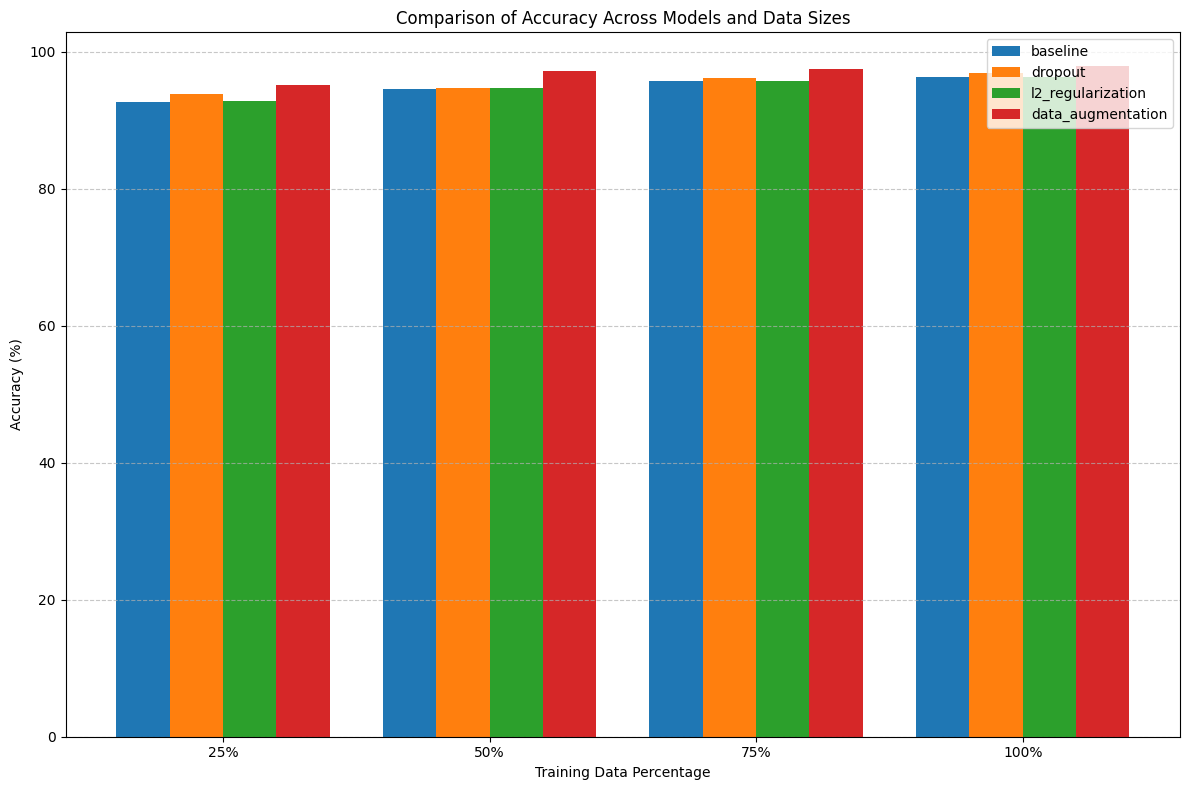

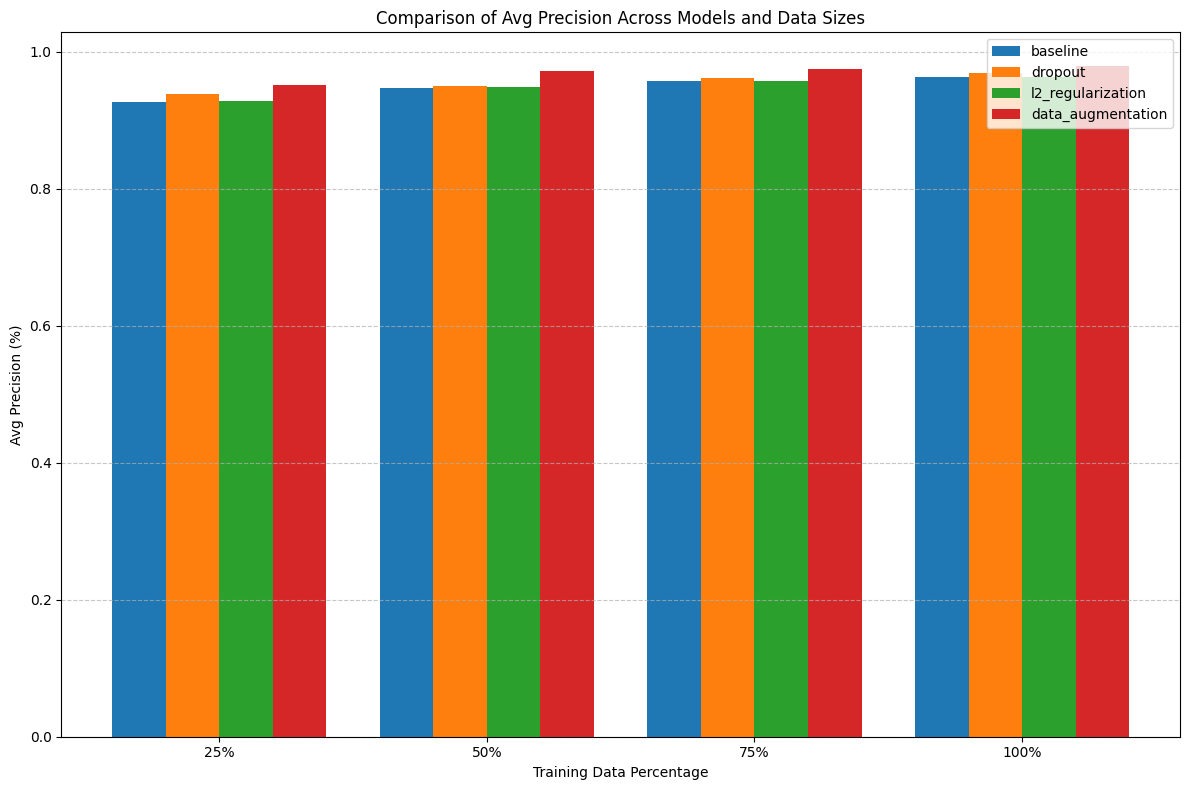

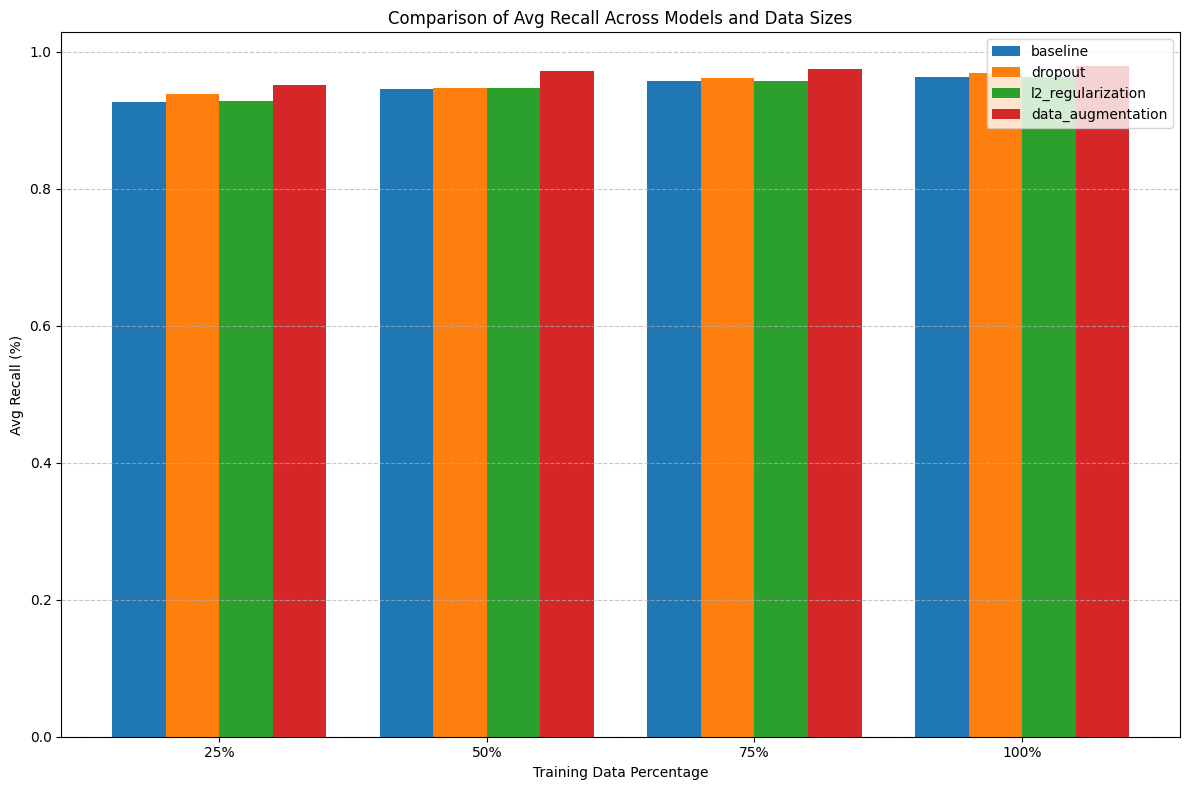


Accuracy Table:
Model | 25% | 50% | 75% | 100%
------------------------------
baseline | 92.65% | 94.61% | 95.67% | 96.32%
dropout | 93.76% | 94.77% | 96.18% | 96.92%
l2_regularization | 92.79% | 94.76% | 95.74% | 96.27%
data_augmentation | 95.14% | 97.18% | 97.45% | 97.93%

Average Precision Table:
Model | 25% | 50% | 75% | 100%
------------------------------
baseline | 0.9268 | 0.9465 | 0.9569 | 0.9634
dropout | 0.9379 | 0.9496 | 0.9620 | 0.9693
l2_regularization | 0.9283 | 0.9479 | 0.9577 | 0.9629
data_augmentation | 0.9520 | 0.9720 | 0.9748 | 0.9793

Average Recall Table:
Model | 25% | 50% | 75% | 100%
------------------------------
baseline | 0.9265 | 0.9461 | 0.9567 | 0.9632
dropout | 0.9376 | 0.9477 | 0.9618 | 0.9692
l2_regularization | 0.9279 | 0.9476 | 0.9574 | 0.9627
data_augmentation | 0.9514 | 0.9718 | 0.9745 | 0.9793


In [ ]:
def plot_comparison_chart(results, metric='accuracy'):
    """
    Plot comparison chart of different models and data percentages

    Args:
        results: Dictionary containing experiment results
        metric: Metric to plot ('accuracy', 'avg_precision', or 'avg_recall')
    """
    # Setup plot
    plt.figure(figsize=(12, 8))

    # Data percentages
    percentages = ['25%', '50%', '75%', '100%']
    x = np.arange(len(percentages))
    width = 0.2

    # Plot bars for each model
    models = list(results.keys())
    for i, model in enumerate(models):
        values = [results[model][p][metric] for p in percentages]
        plt.bar(x + (i - 1.5) * width, values, width, label=model)

    # Add labels and legend
    plt.xlabel('Training Data Percentage')
    plt.ylabel(f'{metric.replace("_", " ").title()} (%)')
    plt.title(f'Comparison of {metric.replace("_", " ").title()} Across Models and Data Sizes')
    plt.xticks(x, percentages)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()

# Plot comparison charts
plot_comparison_chart(results, 'accuracy')
plot_comparison_chart(results, 'avg_precision')
plot_comparison_chart(results, 'avg_recall')

# Create summary tables for the report
def create_summary_tables(results):
    """
    Create summary tables for the report
    """
    # Table 1: Accuracy
    print("\nAccuracy Table:")
    header = "Model | 25% | 50% | 75% | 100%"
    separator = "-" * len(header)
    print(header)
    print(separator)

    for model in results:
        row = f"{model} | "
        for size in ['25%', '50%', '75%', '100%']:
            row += f"{results[model][size]['accuracy']:.2f}% | "
        print(row.rstrip(" | "))

    # Table 2: Average Precision
    print("\nAverage Precision Table:")
    print(header)
    print(separator)

    for model in results:
        row = f"{model} | "
        for size in ['25%', '50%', '75%', '100%']:
            row += f"{results[model][size]['avg_precision']:.4f} | "
        print(row.rstrip(" | "))

    # Table 3: Average Recall
    print("\nAverage Recall Table:")
    print(header)
    print(separator)

    for model in results:
        row = f"{model} | "
        for size in ['25%', '50%', '75%', '100%']:
            row += f"{results[model][size]['avg_recall']:.4f} | "
        print(row.rstrip(" | "))

# Create summary tables
create_summary_tables(results)